In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [2]:
"""
See here https://stackoverflow.com/questions/52371329/fast-spearman-correlation-between-two-pandas-dataframes

Calculate correlation between two matrix, row by row
"""

from numba import njit
import numpy as np


@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape

    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)


def chunk_corr(dmr_data, gene_data, global_mch_data, mask):
    record = corr(a=dmr_data, b=gene_data)
    mean_record = corr(a=dmr_data, b=global_mch_data)
    record -= mean_record
    record[np.abs(record) < 0.2] = 0
    pass_record = csr_matrix(record)
    masked_pass_record = pass_record.multiply(mask)
    return masked_pass_record

In [3]:
# 145 neuronal subtypes
use_clusters = [
    'CA1 Ak5', 'CA1 Chrm3', 'CA1 Kif26a', 'CA1 Lingo2', 'CA1 Ptprg',
    'CA3 Cadm2', 'CA3 Efnb2', 'CA3-St18 Epha5', 'CA3-St18 Nuak1',
    'CA3-St18 Tead1', 'CGE-Lamp5 Dock5', 'CGE-Lamp5 Grid1', 'CGE-Lamp5 Grk5',
    'CGE-Lamp5 Nrxn3', 'CGE-Lamp5 Sorcs1', 'CGE-Vip Ccser1', 'CGE-Vip Clstn2',
    'CGE-Vip Fstl4', 'CGE-Vip Galnt17', 'CGE-Vip Grm8', 'CGE-Vip Ntng1',
    'CGE-Vip Ptprm', 'CGE-Vip Robo1', 'CLA Bcl11a', 'CLA Cdh8', 'CLA Nrp2',
    'CT-L6 Hcrtr2', 'CT-L6 Il1rap', 'CT-L6 Map4', 'CT-L6 Megf9', 'Chd7 Kcnc2',
    'Chd7 Megf11', 'Chd7 Trpc7', 'D1L-Fstl4 Cadm1', 'D1L-Fstl4 Crim1',
    'D1L-Fstl4 Grm3', 'D1L-Fstl4 Sipa1l2', 'D1L-Fstl4 Trps1', 'D1L-PAL Flrt2',
    'D1L-PAL Plcxd3', 'DG dg-all', 'DG-po Bcl11a', 'DG-po Calb2',
    'DG-po Kctd8', 'EP Adcy8', 'EP Rgs8', 'EP Tspan5', 'Foxp2 Dchs2',
    'Foxp2 Homer2', 'Foxp2 Inpp4b', 'Foxp2 Trpc7', 'Gfra1 Gfra1',
    'IG-CA2 Chrm3', 'IG-CA2 Peak1', 'IG-CA2 Xpr1', 'IT-L23 Cux1',
    'IT-L23 Foxp1', 'IT-L23 Ptprt', 'IT-L23 Tenm2', 'IT-L4 Astn2',
    'IT-L4 Shc3', 'IT-L5 Cdh8', 'IT-L5 Etv1', 'IT-L5 Grik3', 'IT-L6 Cadps2',
    'IT-L6 Fstl4', 'IT-L6 Man1c1', 'IT-L6 Oxr1', 'L6b Adcy8', 'L6b Kcnk2',
    'L6b Nrp2', 'L6b Pkhd1', 'LSX-Inh Cacna1i', 'LSX-Inh Dock10',
    'LSX-Inh Enox1', 'LSX-Inh Foxp2', 'LSX-Inh Lats2', 'LSX-Inh Nxph1',
    'LSX-Inh Zeb2', 'MGE-Pvalb Cacna1i', 'MGE-Pvalb Cnih3', 'MGE-Pvalb Entpd3',
    'MGE-Pvalb Gfra2', 'MGE-Pvalb Ptprk', 'MGE-Pvalb Sema5a',
    'MGE-Pvalb Thsd7a', 'MGE-Sst Bmper', 'MGE-Sst Chodl', 'MGE-Sst Dock4',
    'MGE-Sst Etv1', 'MGE-Sst Frmd6', 'MGE-Sst Kcnip4', 'MGE-Sst Ptpre',
    'MGE-Sst Rerg', 'MGE-Sst Rxra', 'MGE-Sst Ubtd1', 'MGE-Sst Unc5b',
    'MSN-D1 Hrh1', 'MSN-D1 Khdrbs3', 'MSN-D1 Ntn1', 'MSN-D1 Plxnc1',
    'MSN-D2 Casz1', 'MSN-D2 Col14a1', 'MSN-D2 Nrp2', 'MSN-D2 Slc24a2',
    'NP-L6 Boc', 'NP-L6 Cntnap4', 'NP-L6 Cntnap5a', 'NP-L6 Cyp7b1',
    'NP-L6 Kcnab1', 'NP-L6 Olfml2b', 'OLF Gabbr2', 'OLF Kcnd3', 'OLF Mapk10',
    'OLF Pag1', 'OLF Trpc4', 'OLF Xkr6', 'OLF-Exc Bmpr1b', 'OLF-Exc Cdh9',
    'OLF-Exc Cux2', 'OLF-Exc Lrrtm3', 'OLF-Exc Pld5', 'OLF-Exc Rmst',
    'OLF-Exc Sgcd', 'OLF-Exc Unc13c', 'PAL-Inh Chat', 'PAL-Inh Deptor',
    'PAL-Inh Igdcc3', 'PAL-Inh Meis1', 'PAL-Inh Meis2', 'PAL-Inh Onecut2',
    'PAL-Inh Ptprd', 'PAL-Inh Rarb', 'PAL-Inh Tcf7l2', 'PAL-Inh Tmem178',
    'PT-L5 Abca12', 'PT-L5 Astn2', 'PT-L5 Kcnh1', 'PT-L5 Nectin1',
    'PT-L5 Plcb4', 'PT-L5 Ptprt', 'PT-L5 Tenm2', 'PT-L5 Tmtc2', 'PT-L5 Unc5b',
    'Unc5c Unc5c'
]
chroms = [
    'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
    'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
    'chr18', 'chr19', 'chrX'
]

In [4]:
global_mch = pd.read_csv('ClusterGlobalmCH.csv', header=None, index_col=0, squeeze=True)[use_clusters]
global_mcg = pd.read_csv('ClusterGlobalmCG.csv', header=None, index_col=0, squeeze=True)[use_clusters]

In [5]:
use_clusters = [i.replace(' ', '_') for i in use_clusters]

In [6]:
chrom = 'chr19'

In [7]:
records = []
for chrom in chroms:
    print(chrom)
    dmr_df = pd.read_msgpack(
        f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/DMR_rate/SubDMR_rate_no_na.{chrom}.msg'
    )
    dmr_df = dmr_df[use_clusters]
    
    dmr_global_mch_corr = corr(dmr_df.values, 
                               global_mch.values.reshape([1, global_mch.size]))
    dmr_global_mch_corr = pd.Series(dmr_global_mch_corr.flat, dmr_df.index)
    records.append(dmr_global_mch_corr)

chr1


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


chr2


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX


In [8]:
dmr_global_mch_corr = pd.concat(records)
dmr_global_mch_corr.fillna(0, inplace=True)
dmr_global_mch_corr.to_msgpack('DMRCorrWithGlobalmCH.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  This is separate from the ipykernel package so we can avoid doing imports until


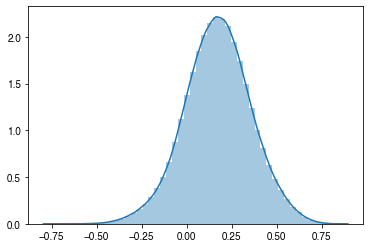

In [9]:
sns.distplot(dmr_global_mch_corr)

In [10]:
records = []
for chrom in chroms:
    print(chrom)
    dmr_df = pd.read_msgpack(
        f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/DMR_rate/SubDMR_rate_no_na.{chrom}.msg'
    )
    dmr_df = dmr_df[use_clusters]
    
    dmr_global_mcg_corr = corr(dmr_df.values, 
                               global_mcg.values.reshape([1, global_mcg.size]))
    dmr_global_mcg_corr = pd.Series(dmr_global_mcg_corr.flat, dmr_df.index)
    records.append(dmr_global_mcg_corr)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX


In [11]:
dmr_global_mcg_corr = pd.concat(records)
dmr_global_mcg_corr.fillna(0, inplace=True)
dmr_global_mcg_corr.to_msgpack('DMRCorrWithGlobalmCG.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  This is separate from the ipykernel package so we can avoid doing imports until


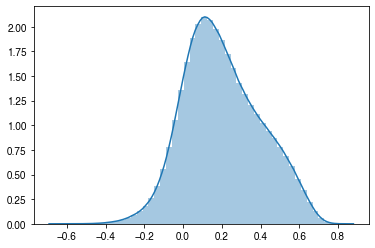

In [12]:
sns.distplot(dmr_global_mcg_corr)